In [3]:
import pandas as pd
import glob

In [4]:
import pandas as pd

# Load datasets
task_events = pd.read_csv("task-events-combined.csv", header=None, nrows=1000000) # to limit RAM usage
job_events = pd.read_csv("job-events-combined.csv", header=None) # num rows = 201604
machine_events = pd.read_csv("machine-events-combined.csv", header=None) # num rows = 37780
task_usage = pd.read_csv("task-usage-combined.csv", header=None, nrows=10000) # RAM usage went to 16 GB for 50 part dataset in full.

C:\Users\thenn\AppData\Local\Temp\ipykernel_35664\3388411010.py:4: DtypeWarning: Columns (9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  task_events = pd.read_csv("task-events-combined.csv", header=None, nrows=1000000) # to limit RAM usage
C:\Users\thenn\AppData\Local\Temp\ipykernel_35664\3388411010.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  job_events = pd.read_csv("job-events-combined.csv", header=None) # num rows = 201604


In [5]:
# Rename columns based on known schema
task_events.columns = [
    "timestamp", "missing_info", "job_id", "task_index", "machine_id",
    "event_type", "user", "scheduling_class", "priority",
    "cpu_request", "memory_request", "disk_space_request",
    "different_machine_constraint"
]

job_events.columns = [
    "timestamp",  "missing_info", "job_id", "event_type", "user", "scheduling_class", 
    "job_name", "logical_job_name" 
]

machine_events.columns = [
    "timestamp", "machine_id", "event_type", "platform_id", "cpu_capacity", "memory_capacity"
]

task_usage.columns = [
    "start_time", "end_time", "job_id", "task_index", "machine_id",
    "cpu_usage", "canonical_memory_usage", "assigned_memory_usage",
    "unmapped_page_cache", "total_page_cache", "maximum_memory_usage", 
    "disk_io_time", "local_disk_space_usage", "max_CPU_usage", "max_disk_io_time",
    "cycles_per_instruction", "memory_acesses_per_instruction", "sample_portion",
    "aggregation_type", "sampled_CPU_usage"
]

### Data cleaning steps

In [6]:
task_events.describe()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,scheduling_class,priority
count,1.000000e+06,291.0,1.000000e+06,1000000.000000,6.712410e+05,1000000.000000,1000000.000000,1000000.000000
mean,1.014730e+10,2.0,5.612440e+09,1173.329325,1.266844e+09,1.321961,0.696239,2.202429
std,9.457859e+09,0.0,1.610940e+09,2971.866984,1.734654e+09,1.614258,0.979833,2.896604
min,0.000000e+00,2.0,3.418309e+06,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,2.0,6.218406e+09,39.000000,6.641062e+06,0.000000,0.000000,0.000000
50%,8.646230e+09,2.0,6.251788e+09,260.000000,3.183507e+08,1.000000,0.000000,2.000000
75%,1.824469e+10,2.0,6.252586e+09,849.000000,2.148956e+09,1.000000,2.000000,2.000000
max,2.849791e+10,2.0,6.253428e+09,20009.000000,6.248207e+09,5.000000,3.000000,11.000000


In [7]:
task_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   timestamp                     1000000 non-null  int64  
 1   missing_info                  291 non-null      float64
 2   job_id                        1000000 non-null  int64  
 3   task_index                    1000000 non-null  float64
 4   machine_id                    671241 non-null   float64
 5   event_type                    1000000 non-null  float64
 6   user                          1000000 non-null  object 
 7   scheduling_class              1000000 non-null  int64  
 8   priority                      1000000 non-null  int64  
 9   cpu_request                   999710 non-null   object 
 10  memory_request                999710 non-null   object 
 11  disk_space_request            999710 non-null   object 
 12  different_machine_constraint 

In [8]:
task_events.head()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machine_constraint
0,0,2.0,3418309,0.1,4.155527e+09,0.2,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
1,0,2.0,3418309,1.0,3.291507e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NaN,NaN,NaN,NaN
2,0,NaN,3418314,0.0,3.938719e+09,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0.0
3,0,NaN,3418314,1.0,3.516186e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0.0
4,0,2.0,3418319,0.0,4.310529e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NaN,NaN,NaN,NaN


In [9]:
job_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201604 entries, 0 to 201603
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         201604 non-null  int64  
 1   missing_info      6 non-null       object 
 2   job_id            201604 non-null  int64  
 3   event_type        201604 non-null  float64
 4   user              201604 non-null  object 
 5   scheduling_class  201604 non-null  int64  
 6   job_name          201604 non-null  object 
 7   logical_job_name  201604 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 12.3+ MB


In [10]:
job_events.head()

,timestamp,missing_info,job_id,event_type,user,scheduling_class,job_name,logical_job_name
0,0,Unnamed: 1,3418309,0.1,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,IHgtoxEBuUTHNbUeVs4hzptMY4n8rZKLbZg+Jh5fNG4=,wAmgn2H74cdoMuSFwJF3NaUEaudVBTZ0/HaNZBwIpEQ=
1,0,NaN,3418314,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,L52XDyhi9x9ChmVBZ1qavOFmnzPeVsvQ2QyGmBZcV4s=,ShNjeaoUeqGV2i9WMKEX9HTeuc9K2Fdfovibt7Mp6qI=
2,0,NaN,3418319,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,vq0IN3BWEbkDjYgYvkrVyH6OWoUoDwFFf3j/syEZzLA=,1A2GM17AzHRcKJcJet/oIF7FOORyFcAOcUSpR9Fqou8=
3,0,NaN,3418324,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,X+Vce15Yu3BCKb7Ttc6hvINAzdfG3NtYEDNNsPdMGKo=,seczVo7MBfi/kH3+eH/40Hxs0l2YKFtXFnamcvMjSQI=
4,0,NaN,3418329,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,EeK3DUWYi1P0vgBTp7wZdUos8UKj/+/FqudTLohMQ9M=,OEeQsaVr4kdGHFwQ2liQlDZ18529HEMmu6B6/3K1cBA=


In [11]:
machine_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37780 entries, 0 to 37779
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        37780 non-null  int64  
 1   machine_id       37780 non-null  int64  
 2   event_type       37780 non-null  float64
 3   platform_id      37780 non-null  object 
 4   cpu_capacity     37748 non-null  float64
 5   memory_capacity  37748 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 1.7+ MB


In [12]:
machine_events.head()

,timestamp,machine_id,event_type,platform_id,cpu_capacity,memory_capacity
0,0,5,0.1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0.0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0.0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0.0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0.0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [13]:
task_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   start_time                      10000 non-null  int64  
 1   end_time                        10000 non-null  int64  
 2   job_id                          10000 non-null  int64  
 3   task_index                      10000 non-null  int64  
 4   machine_id                      10000 non-null  int64  
 5   cpu_usage                       10000 non-null  float64
 6   canonical_memory_usage          10000 non-null  float64
 7   assigned_memory_usage           10000 non-null  float64
 8   unmapped_page_cache             10000 non-null  float64
 9   total_page_cache                10000 non-null  float64
 10  maximum_memory_usage            10000 non-null  object 
 11  disk_io_time                    10000 non-null  float64
 12  local_disk_space_usage          1

In [14]:
task_usage.head()

,start_time,end_time,job_id,task_index,machine_id,cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_io_time,local_disk_space_usage,max_CPU_usage,max_disk_io_time,cycles_per_instruction,memory_acesses_per_instruction,sample_portion,aggregation_type,sampled_CPU_usage
0,600000000,900000000,3418309,0,4155527081,0.001562,0.06787,0.07568,0.001156,0.001503,0.06787.1,0.000003,0.000187,0.039670,0.000357,2.445,0.007243,0.1,1,0.2
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.000320,0.000700,0.06787,0.000006,0.000188,0.033020,0.000929,2.100,0.005791,0.0,1,0.0
2,600000000,900000000,3418314,0,3938719206,0.000307,0.08044,0.09521,0.000282,0.000670,0.08044,0.000005,0.000184,0.023770,0.000786,5.588,0.020800,0.0,1,0.0
3,600000000,900000000,3418314,1,351618647,0.000300,0.08044,0.09521,0.000537,0.000870,0.08044,0.000010,0.000183,0.007919,0.002285,5.198,0.020380,0.0,1,0.0
4,600000000,900000000,3418319,0,431052910,0.000461,0.07715,0.08740,0.000625,0.000852,0.07715,0.000002,0.000204,0.005112,0.000215,2.937,0.009449,0.0,1,0.0


#### Data Cleaning and Preparation for task_events

In [15]:
# drop the missing_info column
task_events = task_events.drop(columns=["missing_info"])


In [16]:
# Drop rows where 'machine_id' is missing
task_events = task_events.dropna(subset=["machine_id"])

In [17]:
task_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671241 entries, 0 to 996723
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   timestamp                     671241 non-null  int64  
 1   job_id                        671241 non-null  int64  
 2   task_index                    671241 non-null  float64
 3   machine_id                    671241 non-null  float64
 4   event_type                    671241 non-null  float64
 5   user                          671241 non-null  object 
 6   scheduling_class              671241 non-null  int64  
 7   priority                      671241 non-null  int64  
 8   cpu_request                   671151 non-null  object 
 9   memory_request                671151 non-null  object 
 10  disk_space_request            671151 non-null  object 
 11  different_machine_constraint  671151 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 

In [18]:
task_events = task_events.dropna(subset=["cpu_request", "memory_request", "disk_space_request"])

In [19]:
task_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671151 entries, 0 to 996723
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   timestamp                     671151 non-null  int64  
 1   job_id                        671151 non-null  int64  
 2   task_index                    671151 non-null  float64
 3   machine_id                    671151 non-null  float64
 4   event_type                    671151 non-null  float64
 5   user                          671151 non-null  object 
 6   scheduling_class              671151 non-null  int64  
 7   priority                      671151 non-null  int64  
 8   cpu_request                   671151 non-null  object 
 9   memory_request                671151 non-null  object 
 10  disk_space_request            671151 non-null  object 
 11  different_machine_constraint  671151 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 

In [20]:
task_events.head()

,timestamp,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machine_constraint
0,0,3418309,0.1,4.155527e+09,0.2,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
2,0,3418314,0.0,3.938719e+09,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0.0
3,0,3418314,1.0,3.516186e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0.0
45,0,3418368,0.0,3.762115e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.0004549,0.0
46,0,3418368,1.0,5.782232e+06,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.0004549,0.0


In [21]:
task_events = task_events.drop(index=0)

In [22]:
task_events.head()

,timestamp,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machine_constraint
2,0,3418314,0.0,3.938719e+09,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0.0
3,0,3418314,1.0,3.516186e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0.0
45,0,3418368,0.0,3.762115e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.0004549,0.0
46,0,3418368,1.0,5.782232e+06,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.0004549,0.0
47,0,3418368,2.0,5.781488e+06,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.0004549,0.0


In [23]:
task_events.describe()

,timestamp,job_id,task_index,machine_id,event_type,scheduling_class,priority
count,6.711500e+05,6.711500e+05,671150.000000,6.711500e+05,671150.000000,671150.000000,671150.000000
mean,9.387813e+09,5.756521e+09,1093.110542,1.266851e+09,1.775171,0.758465,2.700183
std,9.439228e+09,1.293418e+09,2816.955828,1.734664e+09,1.537089,1.027644,3.259044
min,0.000000e+00,3.418309e+06,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,6.186121e+09,48.000000,6.641062e+06,1.000000,0.000000,0.000000
50%,6.183370e+09,6.251753e+09,259.000000,3.183507e+08,1.000000,0.000000,2.000000
75%,1.692446e+10,6.252547e+09,820.000000,2.148956e+09,4.000000,2.000000,2.000000
max,2.849717e+10,6.253428e+09,20009.000000,6.248207e+09,5.000000,3.000000,11.000000


In [24]:
task_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671150 entries, 2 to 996723
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   timestamp                     671150 non-null  int64  
 1   job_id                        671150 non-null  int64  
 2   task_index                    671150 non-null  float64
 3   machine_id                    671150 non-null  float64
 4   event_type                    671150 non-null  float64
 5   user                          671150 non-null  object 
 6   scheduling_class              671150 non-null  int64  
 7   priority                      671150 non-null  int64  
 8   cpu_request                   671150 non-null  object 
 9   memory_request                671150 non-null  object 
 10  disk_space_request            671150 non-null  object 
 11  different_machine_constraint  671150 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 

##### Convert the object types in task_events to int/str/float types

In [25]:
# Convert task_index to int
task_events["task_index"] = task_events["task_index"].astype(int)

In [26]:
task_events[["cpu_request", "memory_request", "disk_space_request"]] = task_events[
    ["cpu_request", "memory_request", "disk_space_request"]
].astype(float)

In [27]:
task_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671150 entries, 2 to 996723
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   timestamp                     671150 non-null  int64  
 1   job_id                        671150 non-null  int64  
 2   task_index                    671150 non-null  int32  
 3   machine_id                    671150 non-null  float64
 4   event_type                    671150 non-null  float64
 5   user                          671150 non-null  object 
 6   scheduling_class              671150 non-null  int64  
 7   priority                      671150 non-null  int64  
 8   cpu_request                   671150 non-null  float64
 9   memory_request                671150 non-null  float64
 10  disk_space_request            671150 non-null  float64
 11  different_machine_constraint  671150 non-null  object 
dtypes: float64(5), int32(1), int64(4), object(2)
memo

In [28]:
task_events['different_machine_constraint'].describe()

count     671150.0
unique         4.0
top            0.0
freq      447916.0
Name: different_machine_constraint, dtype: float64

In [29]:
task_events['different_machine_constraint'].unique()

array(['0.0', '1.0', 1.0, 0.0], dtype=object)

In [30]:
# Convert to integers
task_events['different_machine_constraint'] = task_events['different_machine_constraint'].astype(float).astype(int)

In [31]:
task_events['different_machine_constraint'].unique()

array([0, 1])

In [32]:
task_events['user'] = task_events['user'].astype("string")

In [33]:
task_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671150 entries, 2 to 996723
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   timestamp                     671150 non-null  int64  
 1   job_id                        671150 non-null  int64  
 2   task_index                    671150 non-null  int32  
 3   machine_id                    671150 non-null  float64
 4   event_type                    671150 non-null  float64
 5   user                          671150 non-null  string 
 6   scheduling_class              671150 non-null  int64  
 7   priority                      671150 non-null  int64  
 8   cpu_request                   671150 non-null  float64
 9   memory_request                671150 non-null  float64
 10  disk_space_request            671150 non-null  float64
 11  different_machine_constraint  671150 non-null  int32  
dtypes: float64(5), int32(2), int64(4), string(1)
memo

#### Data Cleaning and Preparation for job_events

In [34]:
 job_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201604 entries, 0 to 201603
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         201604 non-null  int64  
 1   missing_info      6 non-null       object 
 2   job_id            201604 non-null  int64  
 3   event_type        201604 non-null  float64
 4   user              201604 non-null  object 
 5   scheduling_class  201604 non-null  int64  
 6   job_name          201604 non-null  object 
 7   logical_job_name  201604 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 12.3+ MB


In [35]:
# Drop the 'missing_info' column as it has very few non-null values
job_events = job_events.drop(columns=["missing_info"])

##### Convert the object types in task_events to int/str/float types

In [36]:
# Convert 'user' column to string type
job_events['user'] = job_events['user'].astype("string")

In [37]:
job_events['event_type'].describe()

count    201604.000000
mean          1.741037
std           1.878369
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max           6.000000
Name: event_type, dtype: float64

In [38]:
job_events['event_type'].unique()

array([0.1, 0. , 1. , 4. , 5. , 3. , 2. , 6. ])

In [39]:
job_events['job_name'] = job_events['job_name'].astype("string")

In [40]:
job_events['logical_job_name'] = job_events['logical_job_name'].astype("string")

In [41]:
job_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201604 entries, 0 to 201603
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         201604 non-null  int64  
 1   job_id            201604 non-null  int64  
 2   event_type        201604 non-null  float64
 3   user              201604 non-null  string 
 4   scheduling_class  201604 non-null  int64  
 5   job_name          201604 non-null  string 
 6   logical_job_name  201604 non-null  string 
dtypes: float64(1), int64(3), string(3)
memory usage: 10.8 MB


In [42]:
job_events.head()

,timestamp,job_id,event_type,user,scheduling_class,job_name,logical_job_name
0,0,3418309,0.1,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,IHgtoxEBuUTHNbUeVs4hzptMY4n8rZKLbZg+Jh5fNG4=,wAmgn2H74cdoMuSFwJF3NaUEaudVBTZ0/HaNZBwIpEQ=
1,0,3418314,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,L52XDyhi9x9ChmVBZ1qavOFmnzPeVsvQ2QyGmBZcV4s=,ShNjeaoUeqGV2i9WMKEX9HTeuc9K2Fdfovibt7Mp6qI=
2,0,3418319,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,vq0IN3BWEbkDjYgYvkrVyH6OWoUoDwFFf3j/syEZzLA=,1A2GM17AzHRcKJcJet/oIF7FOORyFcAOcUSpR9Fqou8=
3,0,3418324,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,X+Vce15Yu3BCKb7Ttc6hvINAzdfG3NtYEDNNsPdMGKo=,seczVo7MBfi/kH3+eH/40Hxs0l2YKFtXFnamcvMjSQI=
4,0,3418329,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,EeK3DUWYi1P0vgBTp7wZdUos8UKj/+/FqudTLohMQ9M=,OEeQsaVr4kdGHFwQ2liQlDZ18529HEMmu6B6/3K1cBA=


#### Data Cleaning and Preparation for machine_events

In [43]:
machine_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37780 entries, 0 to 37779
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        37780 non-null  int64  
 1   machine_id       37780 non-null  int64  
 2   event_type       37780 non-null  float64
 3   platform_id      37780 non-null  object 
 4   cpu_capacity     37748 non-null  float64
 5   memory_capacity  37748 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 1.7+ MB


In [44]:
# Drop rows where 'cpu_capacity' or 'memory_capacity' have NaN values
machine_events = machine_events.dropna(subset=["cpu_capacity", "memory_capacity"])

In [45]:
machine_events['platform_id'] = machine_events['platform_id'].astype("string")

In [46]:
machine_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37748 entries, 0 to 37779
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        37748 non-null  int64  
 1   machine_id       37748 non-null  int64  
 2   event_type       37748 non-null  float64
 3   platform_id      37748 non-null  string 
 4   cpu_capacity     37748 non-null  float64
 5   memory_capacity  37748 non-null  float64
dtypes: float64(3), int64(2), string(1)
memory usage: 2.0 MB


In [47]:
machine_events.head()

,timestamp,machine_id,event_type,platform_id,cpu_capacity,memory_capacity
0,0,5,0.1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0.0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0.0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0.0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0.0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [48]:
machine_events["machine_id"].unique()

array([         5,          6,          7, ..., 6455072430, 6457070948,
       3623912006], dtype=int64)

#### Data Cleaning and Preparation for task_usage

In [49]:
task_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   start_time                      10000 non-null  int64  
 1   end_time                        10000 non-null  int64  
 2   job_id                          10000 non-null  int64  
 3   task_index                      10000 non-null  int64  
 4   machine_id                      10000 non-null  int64  
 5   cpu_usage                       10000 non-null  float64
 6   canonical_memory_usage          10000 non-null  float64
 7   assigned_memory_usage           10000 non-null  float64
 8   unmapped_page_cache             10000 non-null  float64
 9   total_page_cache                10000 non-null  float64
 10  maximum_memory_usage            10000 non-null  object 
 11  disk_io_time                    10000 non-null  float64
 12  local_disk_space_usage          1

In [50]:
task_usage = task_usage.dropna(subset=['max_disk_io_time', 'cycles_per_instruction', 'memory_acesses_per_instruction'])

In [51]:
task_usage["maximum_memory_usage"] = pd.to_numeric(task_usage["maximum_memory_usage"], errors='coerce')

In [52]:
task_usage = task_usage.dropna(subset=["maximum_memory_usage"])

In [53]:
task_usage.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9433 entries, 1 to 9999
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   start_time                      9433 non-null   int64  
 1   end_time                        9433 non-null   int64  
 2   job_id                          9433 non-null   int64  
 3   task_index                      9433 non-null   int64  
 4   machine_id                      9433 non-null   int64  
 5   cpu_usage                       9433 non-null   float64
 6   canonical_memory_usage          9433 non-null   float64
 7   assigned_memory_usage           9433 non-null   float64
 8   unmapped_page_cache             9433 non-null   float64
 9   total_page_cache                9433 non-null   float64
 10  maximum_memory_usage            9433 non-null   float64
 11  disk_io_time                    9433 non-null   float64
 12  local_disk_space_usage          9433 no

In [54]:
task_usage.head()

,start_time,end_time,job_id,task_index,machine_id,cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_io_time,local_disk_space_usage,max_CPU_usage,max_disk_io_time,cycles_per_instruction,memory_acesses_per_instruction,sample_portion,aggregation_type,sampled_CPU_usage
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.000320,0.000700,0.06787,0.000006,0.000188,0.033020,0.000929,2.100,0.005791,0.0,1,0.0
2,600000000,900000000,3418314,0,3938719206,0.000307,0.08044,0.09521,0.000282,0.000670,0.08044,0.000005,0.000184,0.023770,0.000786,5.588,0.020800,0.0,1,0.0
3,600000000,900000000,3418314,1,351618647,0.000300,0.08044,0.09521,0.000537,0.000870,0.08044,0.000010,0.000183,0.007919,0.002285,5.198,0.020380,0.0,1,0.0
4,600000000,900000000,3418319,0,431052910,0.000461,0.07715,0.08740,0.000625,0.000852,0.07715,0.000002,0.000204,0.005112,0.000215,2.937,0.009449,0.0,1,0.0
5,600000000,900000000,3418319,1,257348783,0.000519,0.07678,0.08740,0.000338,0.000721,0.07678,0.000007,0.000204,0.015080,0.000929,3.055,0.010070,0.0,1,0.0


#### Preprocessing Portion

###### job_events table

We are done with cleaning the raw data. Now we need to do some processing so that the data makes sense.
The job_event table contains multiple datapoints for each job and each entry represents a state in which the job is at a time t. The final entry for a job ID will always be either job FINISH, FAIL, KILL or LOST. We will consider jobs that have a terminal state as FAIL to be FAILED jobs and the jobs with terminal states other than FAIL will be SUCCESS jobs.

In [55]:
len(job_events["job_id"].unique())

68562

I would expect the number of records in job_events table to come down to this number

In [56]:
# Step 1: Group by job_id and aggregate the necessary information
job_events_aggregated = job_events.groupby('job_id').agg(
    state_changes=('job_id', 'size'),  # Count the number of entries for each job_id
    final_event_type=('event_type', 'last'),  # Get the last event_type for each job_id
    scheduling_class=('scheduling_class', 'mean'),  # Take the average scheduling_class
    runtime=('timestamp', lambda x: x.max() - x.min()) # Calculate runtime as the difference between max and min timestamps
).reset_index()

In [57]:
job_events_aggregated

,job_id,state_changes,final_event_type,scheduling_class,runtime
0,3418309,2,1.0,3.0,0
1,3418314,2,1.0,3.0,0
2,3418319,2,1.0,3.0,0
3,3418324,2,1.0,3.0,0
4,3418329,2,1.0,3.0,0
...,...,...,...,...,...
68557,6281351810,2,1.0,2.0,1722824
68558,6281352019,2,1.0,0.0,3636439
68559,6281352255,2,1.0,0.0,3636505
68560,6281353536,2,1.0,0.0,1728534


In [58]:
# Step 2: Subtract 1 from state_changes (to account for the last state)
job_events_aggregated['state_changes'] = job_events_aggregated['state_changes'] - 1

In [59]:
# Step 3: Create the 'target' column based on the final event_type
job_events_aggregated['target'] = job_events_aggregated['final_event_type'].apply(
    lambda x: 1 if x == 3 else 0  # If event_type is 3 (FAIL), target is 1 (FAILED), otherwise 0 (SUCCESS)
)

In [60]:
job_events_aggregated["target"].astype("category").describe()

count     68562
unique        2
top           0
freq      67615
Name: target, dtype: int64

In [61]:
job_events_aggregated["state_changes"].unique()

array([1, 2, 5, 0], dtype=int64)

In [62]:
job_events_aggregated[job_events_aggregated["target"] == 1]

,job_id,state_changes,final_event_type,scheduling_class,runtime,target
1405,5357863310,2,3.0,3.0,238753813745,1
1406,5357863541,2,3.0,3.0,238754588613,1
1416,5389889218,2,3.0,1.0,177170681600,1
1710,5601656023,2,3.0,2.0,155189163750,1
1715,5602834881,2,3.0,2.0,216467857003,1
...,...,...,...,...,...,...
67598,6281053973,2,3.0,0.0,503871862,1
67619,6281068933,2,3.0,2.0,429150297,1
67943,6281173013,2,3.0,0.0,489797124,1
67967,6281182009,2,3.0,2.0,387796330,1


In [63]:
job_events_aggregated[job_events_aggregated["target"] == 0]

,job_id,state_changes,final_event_type,scheduling_class,runtime,target
0,3418309,1,1.0,3.0,0,0
1,3418314,1,1.0,3.0,0,0
2,3418319,1,1.0,3.0,0,0
3,3418324,1,1.0,3.0,0,0
4,3418329,1,1.0,3.0,0,0
...,...,...,...,...,...,...
68557,6281351810,1,1.0,2.0,1722824,0
68558,6281352019,1,1.0,0.0,3636439,0
68559,6281352255,1,1.0,0.0,3636505,0
68560,6281353536,1,1.0,0.0,1728534,0


The data is highly skewed.
Count(FAILED) = 947
Count(SUCCESS) = 67615

##### task_events table

In [64]:
task_events["priority"].unique()

array([ 9, 10,  1,  0,  8, 11,  2], dtype=int64)

In [65]:
len(task_events["job_id"].unique())

10444

In [66]:
task_events["event_type"].unique()

array([0., 1., 4., 3., 2., 5.])

In [67]:
task_events

,timestamp,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machine_constraint
2,0,3418314,0,3.938719e+09,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.12500,0.07446,0.000424,0
3,0,3418314,1,3.516186e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.12500,0.07446,0.000424,0
45,0,3418368,0,3.762115e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.000455,0
46,0,3418368,1,5.782232e+06,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.000455,0
47,0,3418368,2,5.781488e+06,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.000455,0
...,...,...,...,...,...,...,...,...,...,...,...,...
996710,28494100143,6218406404,1093,5.689565e+07,1.0,wh0wq4ZDHzpCBUUq/FeWZ+IrfivM0YMFAGZO3zHdrWc=,2,0,0.04065,0.02069,0.000038,0
996711,28494847593,6253418893,41,4.217903e+09,4.0,njgsHP+OyQXqwu9U5QZ9QC5DS/+IM5Ktlf+o2A1xdTQ=,1,2,0.09998,0.02069,0.000038,1
996713,28496469754,6253377406,9,6.622070e+05,4.0,nHinWYr2Nep8Mr79MMvmYCrGb0NdshyX6mlnZo/Ot+I=,1,2,0.02786,0.02704,0.000077,0
996722,28497173048,6253048491,3,4.547281e+09,4.0,fVUqjeDqXrzcJObPpFT8U1FwH8uBfyRXJQa4zRlwpb4=,1,9,0.06250,0.12720,0.001930,0


In [68]:
job_events[job_events["job_id"] == 5357863310]

,timestamp,job_id,event_type,user,scheduling_class,job_name,logical_job_name
1405,0,5357863310,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,7/zYCKSr/0ZjU/MU/yT771mgZC318kwjZ4yuGln659A=,u9xvioyOvvoHHjSLXKrgA7GimgL4M9G2Z08kNoMUOyg=
5391,0,5357863310,1.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,7/zYCKSr/0ZjU/MU/yT771mgZC318kwjZ4yuGln659A=,u9xvioyOvvoHHjSLXKrgA7GimgL4M9G2Z08kNoMUOyg=
186023,238753813745,5357863310,3.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,7/zYCKSr/0ZjU/MU/yT771mgZC318kwjZ4yuGln659A=,u9xvioyOvvoHHjSLXKrgA7GimgL4M9G2Z08kNoMUOyg=


In [69]:
task_events[task_events["job_id"] == 5357863310]

,timestamp,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machine_constraint
36045,0,5357863310,0,4.304078e+09,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1
36046,0,5357863310,1,7.777383e+06,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1
36047,0,5357863310,2,3.868129e+07,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1
36048,0,5357863310,3,2.787328e+09,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1
36049,0,5357863310,4,9.044680e+05,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1
36050,0,5357863310,5,3.516178e+08,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1
36051,0,5357863310,6,1.777057e+09,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1
36052,0,5357863310,7,4.479132e+09,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1
36053,0,5357863310,8,1.269558e+06,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1
36054,0,5357863310,9,1.979706e+09,0.0,Yr7AeRwXQhhpTE+COdGlpv5XwRFg9pLwME51K07zNLY=,3,9,0.03625,0.006989,0.000006,1


For the Job with id: 5357863310, we can observe that this job was started at timestamp 0 but its status was updated to FAIL at timestamp 238753813745. This leads to the fact that runtime of a job is also a good feature for predicting whether it will fail.
The main observation here is that event_type for a task is not the same as event_type for a job. Because of the fact that the event_type for a job is updated as FAIL but not for each task.
The number of tasks spawned is also a good feature to test with.


In [70]:
task_events[task_events["job_id"] == 5601656023]


,timestamp,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machine_constraint
44451,0,5601656023,0,317497339.0,0.0,XAk+iT/NLGe4Ow+7ARniw9vei1mUmLS0U2w0PFWXEwk=,2,1,0.006248,0.01553,0.000019,0
188787,0,5601656023,0,317497339.0,1.0,XAk+iT/NLGe4Ow+7ARniw9vei1mUmLS0U2w0PFWXEwk=,2,1,0.006248,0.01553,0.000019,0


In [71]:
job_events[job_events["job_id"] == 5601656023]

,timestamp,job_id,event_type,user,scheduling_class,job_name,logical_job_name
1710,0,5601656023,0.0,XAk+iT/NLGe4Ow+7ARniw9vei1mUmLS0U2w0PFWXEwk=,2,58xNk+ak5E89c1cJidovoaKVMZ1QwH91eNT0rcgchIY=,zelNWwMwrGAeqG4/6HMKYw4TrGS3EWVFnaNn/ZqhIUg=
5696,0,5601656023,1.0,XAk+iT/NLGe4Ow+7ARniw9vei1mUmLS0U2w0PFWXEwk=,2,58xNk+ak5E89c1cJidovoaKVMZ1QwH91eNT0rcgchIY=,zelNWwMwrGAeqG4/6HMKYw4TrGS3EWVFnaNn/ZqhIUg=
121422,155189163750,5601656023,3.0,XAk+iT/NLGe4Ow+7ARniw9vei1mUmLS0U2w0PFWXEwk=,2,58xNk+ak5E89c1cJidovoaKVMZ1QwH91eNT0rcgchIY=,zelNWwMwrGAeqG4/6HMKYw4TrGS3EWVFnaNn/ZqhIUg=


Lets look at a case where a task failed. Will the job also be updated as failed?

In [72]:
task_events[task_events["event_type"] == 3]

,timestamp,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machine_constraint
277330,600047716,5285926325,0,1.302287e+06,3.0,2V0B3LFwQ48zIHlDcpiCQTAG+f4Nk64GVADb8vfarvA=,0,9,0.062500,0.006218,0.000038,0
277377,604046168,6250345153,878,2.947718e+08,3.0,4Ubmtvv/epOnUEgegvGV9mCxxcZkV4z/Dm8RY/9SEYw=,0,0,0.068730,0.011930,0.000115,0
277493,613709355,6184995193,229,6.567448e+06,3.0,rNyxTd1B3RnDJBIofzoVksjnmaJEN+hW5W+yRHo2xsM=,3,9,0.187500,0.031070,0.000019,0
277596,624892990,5285926325,0,3.206464e+07,3.0,2V0B3LFwQ48zIHlDcpiCQTAG+f4Nk64GVADb8vfarvA=,0,9,0.062500,0.006218,0.000038,0
277825,641937157,6251620795,2,3.452873e+08,3.0,fVUqjeDqXrzcJObPpFT8U1FwH8uBfyRXJQa4zRlwpb4=,1,9,0.062500,0.127200,0.001930,0
...,...,...,...,...,...,...,...,...,...,...,...,...
996548,28471597159,4297552690,0,2.274791e+09,3.0,qzYKr1BqweZKofd4U2tWF0VxZEbJhjG/LunlAwkI1kM=,2,9,0.006248,0.007950,0.000008,1
996596,28477829375,6252870873,7,1.429189e+09,3.0,dHdSdN5N9w0NKfrXrRG+XGefTgoOKVidH0CDthqEbS4=,2,0,0.006248,0.063600,0.000154,0
996607,28479322495,5285926325,0,3.175084e+08,3.0,2V0B3LFwQ48zIHlDcpiCQTAG+f4Nk64GVADb8vfarvA=,0,9,0.062500,0.006218,0.000038,0
996674,28490770203,6253352761,14,2.574072e+08,3.0,dT4PmDV8BInbmhDgMzu5obSCBm763C/HqMpBHL96dBI=,2,9,0.012500,0.095460,0.000386,0


In [73]:
job_events[job_events["job_id"] == 5285926325]

,timestamp,job_id,event_type,user,scheduling_class,job_name,logical_job_name
1304,0,5285926325,0.0,2V0B3LFwQ48zIHlDcpiCQTAG+f4Nk64GVADb8vfarvA=,0,BQKHTfVK2TP+sNDNhnB2mfY3P73deoXKkFq9Jz/E7/A=,kS58JehN5UaYicL7h/i3OfbqMoFLv8AnJh84y0e59oc=
5290,0,5285926325,1.0,2V0B3LFwQ48zIHlDcpiCQTAG+f4Nk64GVADb8vfarvA=,0,BQKHTfVK2TP+sNDNhnB2mfY3P73deoXKkFq9Jz/E7/A=,kS58JehN5UaYicL7h/i3OfbqMoFLv8AnJh84y0e59oc=


As we can see here, the job_id hasn't been updated as Failed. It may be due to the fact that we are unable to access the entire dataset of 40 GB.

In [74]:
job_events[job_events["job_id"] == 6250345153]

,timestamp,job_id,event_type,user,scheduling_class,job_name,logical_job_name
3835,0,6250345153,0.0,4Ubmtvv/epOnUEgegvGV9mCxxcZkV4z/Dm8RY/9SEYw=,0,iy9VqNlvsF6SooFnNj7AoBJjjyMJ5+ub/Nl/sPY9+zQ=,qQlJuXams7Rkgyrzuwpky6zU4YTTveU4jEtnDekLbpI=
7820,0,6250345153,1.0,4Ubmtvv/epOnUEgegvGV9mCxxcZkV4z/Dm8RY/9SEYw=,0,iy9VqNlvsF6SooFnNj7AoBJjjyMJ5+ub/Nl/sPY9+zQ=,qQlJuXams7Rkgyrzuwpky6zU4YTTveU4jEtnDekLbpI=
10376,5128936694,6250345153,5.0,4Ubmtvv/epOnUEgegvGV9mCxxcZkV4z/Dm8RY/9SEYw=,0,iy9VqNlvsF6SooFnNj7AoBJjjyMJ5+ub/Nl/sPY9+zQ=,qQlJuXams7Rkgyrzuwpky6zU4YTTveU4jEtnDekLbpI=


Here the Job was killed.

In [75]:
job_events[job_events["job_id"] == 6253352761]

,timestamp,job_id,event_type,user,scheduling_class,job_name,logical_job_name
26410,27188098515,6253352761,0.0,dT4PmDV8BInbmhDgMzu5obSCBm763C/HqMpBHL96dBI=,2,/6kswW4Br34zRkLcVQ90iDZiUW92ElYjUA8N6cOPu3E=,Jdp/0dpwW+BL7H/J7D73zhNThXHEmOaaQcdgD/PaJFI=
26413,27189762849,6253352761,1.0,dT4PmDV8BInbmhDgMzu5obSCBm763C/HqMpBHL96dBI=,2,/6kswW4Br34zRkLcVQ90iDZiUW92ElYjUA8N6cOPu3E=,Jdp/0dpwW+BL7H/J7D73zhNThXHEmOaaQcdgD/PaJFI=
28461,30664517786,6253352761,5.0,dT4PmDV8BInbmhDgMzu5obSCBm763C/HqMpBHL96dBI=,2,/6kswW4Br34zRkLcVQ90iDZiUW92ElYjUA8N6cOPu3E=,Jdp/0dpwW+BL7H/J7D73zhNThXHEmOaaQcdgD/PaJFI=


In [76]:
job_events[job_events["job_id"] == 6252870873]

,timestamp,job_id,event_type,user,scheduling_class,job_name,logical_job_name
20450,19735002463,6252870873,0.0,dHdSdN5N9w0NKfrXrRG+XGefTgoOKVidH0CDthqEbS4=,2,MMxm16BOOrLnmIk0UFQTo1x09Yrhcm6Mg4XzQEQlv7c=,7iIYATwSdxCfAbiVIHi2qooUT3Xu+O6686FVIym78PY=
20451,19736445189,6252870873,1.0,dHdSdN5N9w0NKfrXrRG+XGefTgoOKVidH0CDthqEbS4=,2,MMxm16BOOrLnmIk0UFQTo1x09Yrhcm6Mg4XzQEQlv7c=,7iIYATwSdxCfAbiVIHi2qooUT3Xu+O6686FVIym78PY=
66830,86409476478,6252870873,5.0,dHdSdN5N9w0NKfrXrRG+XGefTgoOKVidH0CDthqEbS4=,2,MMxm16BOOrLnmIk0UFQTo1x09Yrhcm6Mg4XzQEQlv7c=,7iIYATwSdxCfAbiVIHi2qooUT3Xu+O6686FVIym78PY=


Lets look at the intersection between task_events and job_events for event_type == 3

In [77]:
task_failed = task_events[task_events["event_type"] == 3]
task_failed_jobids = list(task_failed["job_id"].unique())

In [ ]:
task_failed_jobids

In [79]:
task_failed_job_events = job_events_aggregated[job_events_aggregated["job_id"].isin(task_failed_jobids)]

In [80]:
task_failed_job_events[task_failed_job_events["target"] == 1]

,job_id,state_changes,final_event_type,scheduling_class,runtime,target
2756,6154617933,2,3.0,2.0,71751890822,1
3282,6221861800,2,3.0,0.0,112529561441,1
3788,6248864386,2,3.0,1.0,19485531557,1
3800,6249158050,2,3.0,0.0,13923480155,1
3826,6250156944,2,3.0,0.0,46991160085,1
...,...,...,...,...,...,...
9930,6253276803,2,3.0,1.0,324474840,1
9994,6253288354,2,3.0,1.0,337019422,1
10182,6253357946,2,3.0,1.0,35921855,1
10240,6253375627,2,3.0,1.0,154407882,1


In [81]:
task_failed_job_events[task_failed_job_events["target"] == 0]

,job_id,state_changes,final_event_type,scheduling_class,runtime,target
96,609252510,1,1.0,2.0,0,0
99,609252516,1,1.0,2.0,0,0
100,609260421,1,1.0,2.0,0,0
119,698645235,1,1.0,2.0,0,0
156,1202636597,2,5.0,3.0,147675649523,0
...,...,...,...,...,...,...
9773,6253221024,2,5.0,1.0,1242236468,0
9981,6253286236,2,4.0,1.0,146697455,0
10010,6253291072,2,5.0,0.0,7117789372,0
10033,6253305348,2,5.0,0.0,269655597,0


We can see that if a task fails, then the number of jobs that fail along with it is 104. The number of jobs succeeded is 225.
Since we haven't considered the entire dataset, we can assume that the number of tasks failed is a good feature for job failure prediction.

In [82]:
task_events

,timestamp,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machine_constraint
2,0,3418314,0,3.938719e+09,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.12500,0.07446,0.000424,0
3,0,3418314,1,3.516186e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.12500,0.07446,0.000424,0
45,0,3418368,0,3.762115e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.000455,0
46,0,3418368,1,5.782232e+06,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.000455,0
47,0,3418368,2,5.781488e+06,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.03125,0.08691,0.000455,0
...,...,...,...,...,...,...,...,...,...,...,...,...
996710,28494100143,6218406404,1093,5.689565e+07,1.0,wh0wq4ZDHzpCBUUq/FeWZ+IrfivM0YMFAGZO3zHdrWc=,2,0,0.04065,0.02069,0.000038,0
996711,28494847593,6253418893,41,4.217903e+09,4.0,njgsHP+OyQXqwu9U5QZ9QC5DS/+IM5Ktlf+o2A1xdTQ=,1,2,0.09998,0.02069,0.000038,1
996713,28496469754,6253377406,9,6.622070e+05,4.0,nHinWYr2Nep8Mr79MMvmYCrGb0NdshyX6mlnZo/Ot+I=,1,2,0.02786,0.02704,0.000077,0
996722,28497173048,6253048491,3,4.547281e+09,4.0,fVUqjeDqXrzcJObPpFT8U1FwH8uBfyRXJQa4zRlwpb4=,1,9,0.06250,0.12720,0.001930,0


In [83]:
# Group by 'job_id' and perform aggregations
task_events_aggregated = task_events.groupby('job_id').agg(
    task_count=('task_index', 'count'),  # Total number of tasks
    task_failure_count=('event_type', lambda x: (x == 3).sum()),  # Count tasks with event_type == 3
    avg_scheduling_class=('scheduling_class', 'mean'),  # Mean scheduling_class
    avg_priority=('priority', 'mean'),  # Mean priority
    total_memory_request=('memory_request', 'sum'),  # Sum memory_request
    total_cpu_request=('cpu_request', 'sum'),  # Sum cpu_request
    total_disk_space_request=('disk_space_request', 'sum'),  # Sum disk_space_request
    total_different_machine_constraint=('different_machine_constraint', 'sum')  # Sum different_machine_constraint
).reset_index()

# Display the result
task_events_aggregated.head()

,job_id,task_count,task_failure_count,avg_scheduling_class,avg_priority,total_memory_request,total_cpu_request,total_disk_space_request,total_different_machine_constraint
0,3418309,2,0,3.0,9.0,0.14892,0.2500,0.000849,0
1,3418314,4,0,3.0,9.0,0.33838,0.3750,0.001789,0
2,3418319,2,0,3.0,9.0,0.17382,0.0625,0.000910,0
3,3418324,2,0,3.0,9.0,0.17626,0.1250,0.000940,0
4,3418329,3,0,3.0,9.0,0.29772,0.3750,0.003147,0


In [84]:
task_events_aggregated.shape[0]

10444

Lets look at task_usage table

In [85]:
task_usage

,start_time,end_time,job_id,task_index,machine_id,cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_io_time,local_disk_space_usage,max_CPU_usage,max_disk_io_time,cycles_per_instruction,memory_acesses_per_instruction,sample_portion,aggregation_type,sampled_CPU_usage
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.000320,0.000700,0.06787,0.000006,0.000188,0.033020,0.000929,2.100,0.005791,0.0,1,0.0
2,600000000,900000000,3418314,0,3938719206,0.000307,0.08044,0.09521,0.000282,0.000670,0.08044,0.000005,0.000184,0.023770,0.000786,5.588,0.020800,0.0,1,0.0
3,600000000,900000000,3418314,1,351618647,0.000300,0.08044,0.09521,0.000537,0.000870,0.08044,0.000010,0.000183,0.007919,0.002285,5.198,0.020380,0.0,1,0.0
4,600000000,900000000,3418319,0,431052910,0.000461,0.07715,0.08740,0.000625,0.000852,0.07715,0.000002,0.000204,0.005112,0.000215,2.937,0.009449,0.0,1,0.0
5,600000000,900000000,3418319,1,257348783,0.000519,0.07678,0.08740,0.000338,0.000721,0.07678,0.000007,0.000204,0.015080,0.000929,3.055,0.010070,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,600000000,900000000,3996125377,21,484486351,0.067380,0.01097,0.01331,0.000984,0.001379,0.01144,0.000156,0.000043,0.214100,0.007935,1.123,0.001441,0.0,1,0.0
9996,600000000,900000000,3996125377,22,1335771,0.063840,0.01132,0.01332,0.001181,0.001587,0.01184,0.000087,0.000044,0.204100,0.005432,1.115,0.001461,0.0,1,0.0
9997,600000000,900000000,3996125377,23,4486057692,0.069210,0.01074,0.01334,0.000527,0.001095,0.01103,0.000086,0.000012,0.204600,0.003502,1.176,0.001623,0.0,1,0.0
9998,600000000,900000000,3996125377,24,257406599,0.064700,0.01132,0.01332,0.001038,0.001440,0.01186,0.000094,0.000045,0.201400,0.006287,1.077,0.001355,0.0,1,0.0


In [86]:
job_events_aggregated[job_events_aggregated["job_id"] == 3418309]

,job_id,state_changes,final_event_type,scheduling_class,runtime,target
0,3418309,1,1.0,3.0,0,0


In [87]:
task_usage[task_usage["job_id"] == 3418309]

,start_time,end_time,job_id,task_index,machine_id,cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_io_time,local_disk_space_usage,max_CPU_usage,max_disk_io_time,cycles_per_instruction,memory_acesses_per_instruction,sample_portion,aggregation_type,sampled_CPU_usage
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.00032,0.0007,0.06787,0.000006,0.000188,0.03302,0.000929,2.1,0.005791,0.0,1,0.0


In [88]:
task_usage_aggregated = task_usage.groupby(['job_id', 'task_index']).agg(
    unique_machine_ids=('machine_id', 'nunique'),  # Count the number of unique machine_ids
    avg_cpu_usage=('cpu_usage', 'mean'),  # Average of cpu_usage
    avg_canonical_memory_usage=('canonical_memory_usage', 'mean'),  # Average of canonical_memory_usage
    avg_assigned_memory_usage=('assigned_memory_usage', 'mean'),  # Average of assigned_memory_usage
    avg_unmapped_page_cache=('unmapped_page_cache', 'mean'),  # Average of unmapped_page_cache
    avg_total_page_cache=('total_page_cache', 'mean'),  # Average of total_page_cache
    avg_maximum_memory_usage=('maximum_memory_usage', 'mean'),  # Average of maximum_memory_usage
    avg_disk_io_time=('disk_io_time', 'mean'),  # Average of disk_io_time
    avg_local_disk_space_usage=('local_disk_space_usage', 'mean'),  # Average of local_disk_space_usage
    avg_max_CPU_usage=('max_CPU_usage', 'mean'),  # Average of max_CPU_usage
    avg_max_disk_io_time=('max_disk_io_time', 'mean'),  # Average of max_disk_io_time
    avg_cycles_per_instruction=('cycles_per_instruction', 'mean'),  # Average of cycles_per_instruction
    avg_memory_accesses_per_instruction=('memory_acesses_per_instruction', 'mean'),  # Average of memory_acesses_per_instruction
).reset_index()


In [89]:
task_usage_aggregated.head()

,job_id,task_index,unique_machine_ids,avg_cpu_usage,avg_canonical_memory_usage,avg_assigned_memory_usage,avg_unmapped_page_cache,avg_total_page_cache,avg_maximum_memory_usage,avg_disk_io_time,avg_local_disk_space_usage,avg_max_CPU_usage,avg_max_disk_io_time,avg_cycles_per_instruction,avg_memory_accesses_per_instruction
0,3418309,1,1,0.001568,0.06787,0.07556,0.000320,0.000700,0.06787,0.000006,0.000188,0.033020,0.000929,2.100,0.005791
1,3418314,0,1,0.000307,0.08044,0.09521,0.000282,0.000670,0.08044,0.000005,0.000184,0.023770,0.000786,5.588,0.020800
2,3418314,1,1,0.000300,0.08044,0.09521,0.000537,0.000870,0.08044,0.000010,0.000183,0.007919,0.002285,5.198,0.020380
3,3418319,0,1,0.000461,0.07715,0.08740,0.000625,0.000852,0.07715,0.000002,0.000204,0.005112,0.000215,2.937,0.009449
4,3418319,1,1,0.000519,0.07678,0.08740,0.000338,0.000721,0.07678,0.000007,0.000204,0.015080,0.000929,3.055,0.010070


In [90]:
len(task_usage_aggregated["job_id"].unique())

542

In [91]:
task_usage_final_aggregated = task_usage_aggregated.groupby('job_id').agg(
    num_machines_utilised=('unique_machine_ids', 'sum'),  # total number of unique machines
    max_avg_cpu_usage=('avg_cpu_usage', 'max'),  # Maximum average CPU usage
    max_avg_canonical_memory_usage=('avg_canonical_memory_usage', 'max'),  # Maximum average canonical memory usage
    max_avg_assigned_memory_usage=('avg_assigned_memory_usage', 'max'),  # Maximum average assigned memory usage
    max_avg_unmapped_page_cache=('avg_unmapped_page_cache', 'max'),  # Maximum average unmapped page cache
    max_avg_total_page_cache=('avg_total_page_cache', 'max'),  # Maximum average total page cache
    max_avg_maximum_memory_usage=('avg_maximum_memory_usage', 'max'),  # Maximum average maximum memory usage
    max_avg_disk_io_time=('avg_disk_io_time', 'max'),  # Maximum average disk I/O time
    max_avg_local_disk_space_usage=('avg_local_disk_space_usage', 'max'),  # Maximum average local disk space usage
    max_avg_cycles_per_instruction=('avg_cycles_per_instruction', 'max'),  # Maximum average cycles per instruction
    max_avg_memory_accesses_per_instruction=('avg_memory_accesses_per_instruction', 'max'),  # Maximum average memory accesses per instruction
).reset_index()

# Display the result
task_usage_final_aggregated.head()

,job_id,num_machines_utilised,max_avg_cpu_usage,max_avg_canonical_memory_usage,max_avg_assigned_memory_usage,max_avg_unmapped_page_cache,max_avg_total_page_cache,max_avg_maximum_memory_usage,max_avg_disk_io_time,max_avg_local_disk_space_usage,max_avg_cycles_per_instruction,max_avg_memory_accesses_per_instruction
0,3418309,1,0.001568,0.06787,0.07556,0.000320,0.000700,0.06787,0.000006,0.000188,2.100,0.005791
1,3418314,2,0.000307,0.08044,0.09521,0.000537,0.000870,0.08044,0.000010,0.000184,5.588,0.020800
2,3418319,2,0.000519,0.07715,0.08740,0.000625,0.000852,0.07715,0.000007,0.000204,3.055,0.010070
3,3418324,2,0.000380,0.08118,0.08936,0.000407,0.000732,0.08118,0.000006,0.000197,4.088,0.015690
4,3418329,3,0.002705,0.09106,0.10110,0.000448,0.000855,0.09106,0.000007,0.000358,2.215,0.006107


In [92]:
task_usage_final_aggregated.shape[0]

542

#### Final compilation into a single table format

In [100]:
# Merge task_events_aggregated with job_events_aggregated on job_id
merged_data = pd.merge(task_events_aggregated, job_events_aggregated, on="job_id", how="inner")

# Merge the result with task_usage_final_aggregated on job_id
#final_combined_data = pd.merge(merged_data, task_usage_final_aggregated, on="job_id", how="inner")
final_combined_data = merged_data

In [101]:
final_combined_data = final_combined_data.drop("final_event_type", axis=1)

In [102]:
final_combined_data[final_combined_data["target"] == 1]

,job_id,task_count,task_failure_count,avg_scheduling_class,avg_priority,total_memory_request,total_cpu_request,total_disk_space_request,total_different_machine_constraint,state_changes,scheduling_class,runtime,target
1400,5357863310,20,0,3.0,9.0,0.139780,0.725000,0.000114,20,2,3.0,238753813745,1
1401,5357863541,2,0,3.0,9.0,0.009324,0.125000,0.000107,0,2,3.0,238754588613,1
1411,5389889218,20,0,1.0,1.0,0.186460,0.000000,0.000839,20,2,1.0,177170681600,1
1705,5601656023,2,0,2.0,1.0,0.031060,0.012496,0.000038,0,2,2.0,155189163750,1
1709,5602834881,3,0,2.0,1.0,0.009327,0.093750,0.000114,0,2,2.0,216467857003,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,6253276803,820,10,1.0,2.0,16.965800,81.983600,0.031283,820,2,1.0,324474840,1
9970,6253288354,820,10,1.0,2.0,16.965800,81.983600,0.031283,820,2,1.0,337019422,1
10158,6253357946,2,1,1.0,2.0,0.007950,0.025000,0.000019,0,2,1.0,35921855,1
10216,6253375627,2,1,1.0,2.0,0.007950,0.025000,0.000038,0,2,1.0,154407882,1


In [103]:
final_combined_data[final_combined_data["target"] == 0]

,job_id,task_count,task_failure_count,avg_scheduling_class,avg_priority,total_memory_request,total_cpu_request,total_disk_space_request,total_different_machine_constraint,state_changes,scheduling_class,runtime,target
0,3418309,2,0,3.0,9.0,0.148920,0.250000,0.000849,0,1,3.0,0,0
1,3418314,4,0,3.0,9.0,0.338380,0.375000,0.001789,0,1,3.0,0,0
2,3418319,2,0,3.0,9.0,0.173820,0.062500,0.000910,0,1,3.0,0,0
3,3418324,2,0,3.0,9.0,0.176260,0.125000,0.000940,0,1,3.0,0,0
4,3418329,3,0,3.0,9.0,0.297720,0.375000,0.003147,0,1,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10439,6253423647,1,0,2.0,8.0,0.004662,0.009369,0.000075,0,2,2.0,87688032,0
10440,6253423701,1,0,2.0,0.0,0.015530,0.006248,0.000038,0,2,2.0,78345126,0
10441,6253423730,3,0,0.0,2.0,0.005916,0.018744,0.000226,0,2,0.0,86322008,0
10442,6253424069,1,0,2.0,0.0,0.004662,0.006248,0.000038,0,2,2.0,86322012,0


This is highly skewed. Count(FAIL) = 30 Count(SUCCESS) = 3912

In [107]:
y.value_counts()

target
0    10314
1      130
Name: count, dtype: int64

In [108]:
y_resampled.value_counts()

target
0    10314
1    10314
Name: count, dtype: int64

In [110]:
X_resampled.shape[0]

20628

In [111]:
y_resampled.shape[0]

20628

In [105]:
import sklearn
from imblearn.over_sampling import SMOTE

X = final_combined_data.drop(columns=['target'])  # Features
y = final_combined_data['target']  # Target (FAIL=1, SUCCESS=0)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#### Separate into train, test and validation sets

Withold the data for testing and validation

In [112]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target (y)
# X = final_combined_data.drop(columns=['target'])  # Features
# y = final_combined_data['target']  # Target variable (FAIL/SUCCESS)

# First, split into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Then, split the train+validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

# Check sizes
print(f"Training Set: {X_train.shape}, {y_train.shape}")
print(f"Validation Set: {X_val.shape}, {y_val.shape}")
print(f"Test Set: {X_test.shape}, {y_test.shape}")

Training Set: (13201, 12), (13201,)
Validation Set: (3301, 12), (3301,)
Test Set: (4126, 12), (4126,)


In [113]:
y_train.unique()

array([0, 1], dtype=int64)

In [114]:
y_val.unique()

array([0, 1], dtype=int64)

In [115]:
y_test.unique()

array([1, 0], dtype=int64)

### Data Analysis

Brief overview

In [116]:
X_train.describe()

,job_id,task_count,task_failure_count,avg_scheduling_class,avg_priority,total_memory_request,total_cpu_request,total_disk_space_request,total_different_machine_constraint,state_changes,scheduling_class,runtime
count,1.320100e+04,13201.000000,13201.000000,13201.000000,13201.000000,13201.000000,13201.000000,13201.000000,13201.000000,13201.000000,13201.000000,1.320100e+04
mean,6.035845e+09,311.670631,19.395122,1.167981,4.102054,6.805298,11.884060,0.070778,90.648511,1.846906,1.167981,1.837500e+10
std,7.535666e+08,2060.882439,120.092576,0.786664,3.547118,36.281963,43.012858,0.809230,368.963832,0.360092,0.786664,5.093681e+10
min,3.418319e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00
25%,6.238013e+09,2.000000,0.000000,1.000000,1.000000,0.009324,0.018738,0.000031,0.000000,2.000000,1.000000,3.821793e+07
50%,6.252227e+09,2.000000,0.000000,1.000000,2.000000,0.031800,0.074950,0.000097,0.000000,2.000000,1.000000,1.551108e+08
75%,6.252722e+09,12.000000,1.000000,1.958286,8.000000,0.214400,0.409440,0.000772,0.000000,2.000000,1.958286,6.889435e+08
max,6.253428e+09,41434.000000,1126.000000,3.000000,11.000000,658.800600,517.925000,16.755910,7759.000000,2.000000,3.000000,2.553739e+11


In [117]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13201 entries, 8035 to 11251
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   job_id                              13201 non-null  int64  
 1   task_count                          13201 non-null  int64  
 2   task_failure_count                  13201 non-null  int64  
 3   avg_scheduling_class                13201 non-null  float64
 4   avg_priority                        13201 non-null  float64
 5   total_memory_request                13201 non-null  float64
 6   total_cpu_request                   13201 non-null  float64
 7   total_disk_space_request            13201 non-null  float64
 8   total_different_machine_constraint  13201 non-null  int32  
 9   state_changes                       13201 non-null  int64  
 10  scheduling_class                    13201 non-null  float64
 11  runtime                             13201 n

In [118]:
X_train.isnull().sum()

job_id                                0
task_count                            0
task_failure_count                    0
avg_scheduling_class                  0
avg_priority                          0
total_memory_request                  0
total_cpu_request                     0
total_disk_space_request              0
total_different_machine_constraint    0
state_changes                         0
scheduling_class                      0
runtime                               0
dtype: int64

In [119]:
y_train.value_counts()

target
1    6601
0    6600
Name: count, dtype: int64

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
train_data = pd.concat([X_train, y_train], axis=1)

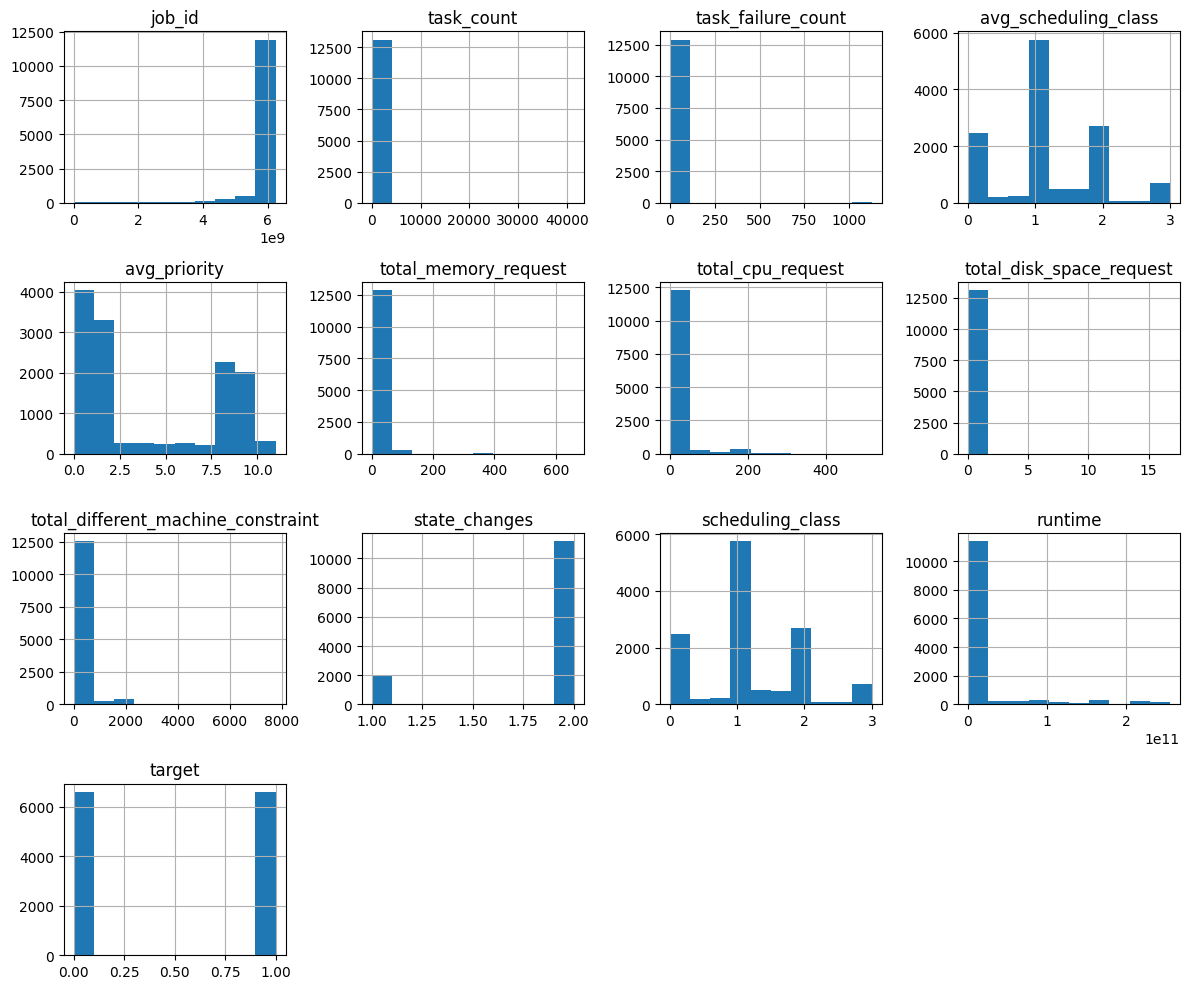

In [122]:
# Histograms for numerical columns
train_data.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

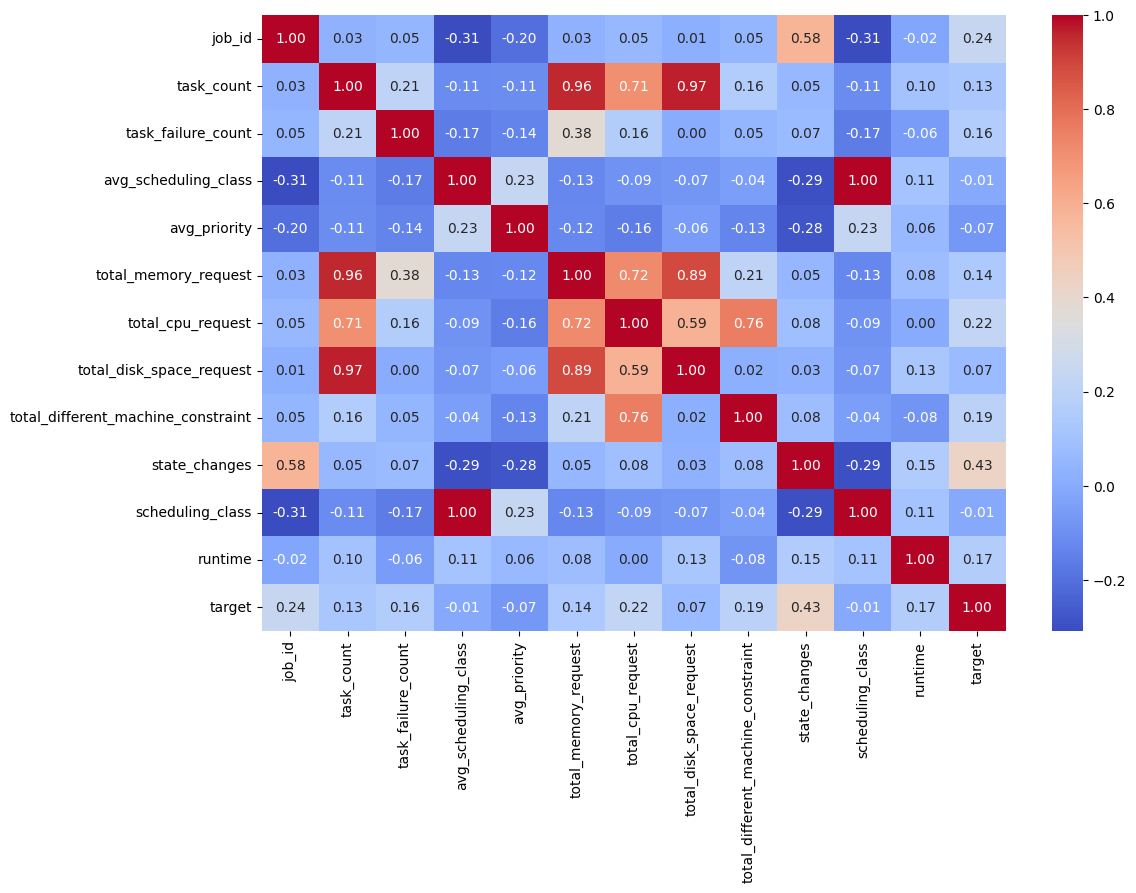

In [123]:
# Correlation heatmap for numerical features
corr = train_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.2f')
plt.show()

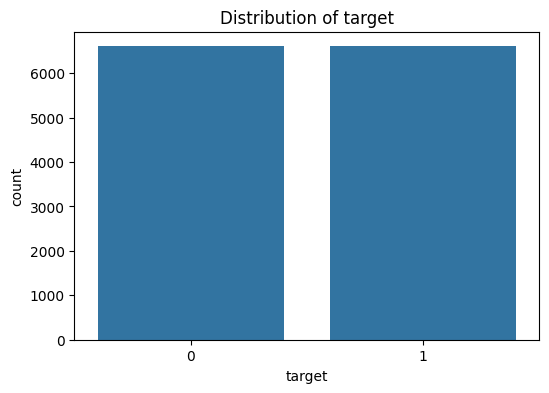

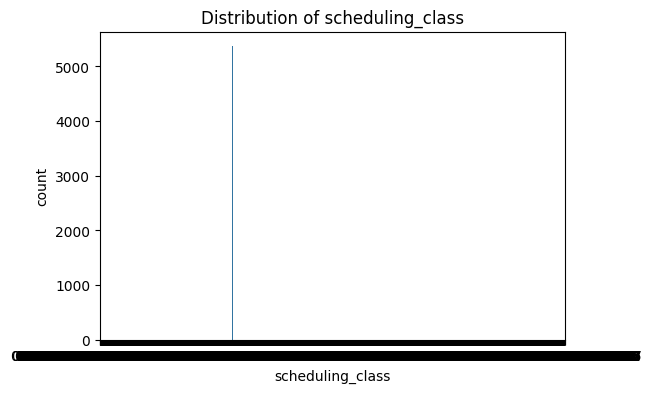

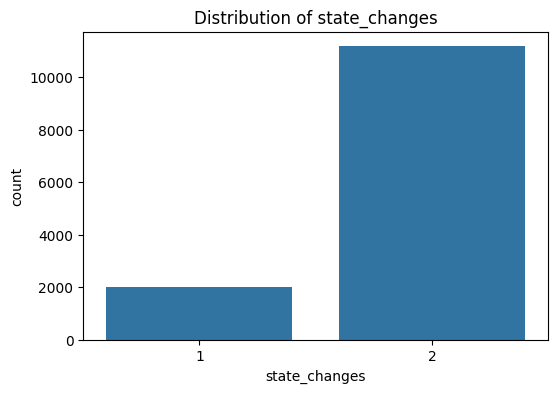

In [124]:
# Distribution of categorical columns (e.g., target, scheduling_class, event_type)
categorical_columns = ['target', 'scheduling_class', 'state_changes']#, 'num_machines_utilised']

for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train_data, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()

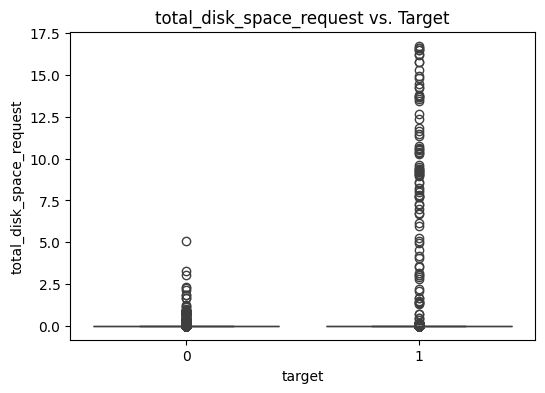

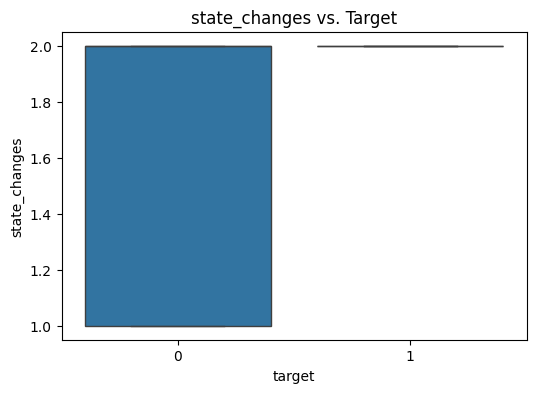

total_disk_space_request           state_changes          
                           mean       std          mean       std
target                                                           
0                      0.016041  0.130692      1.693788  0.460954
1                      0.125507  1.134300      2.000000  0.000000

In [125]:
# Boxplot of numerical columns vs. target
numerical_columns = ['total_disk_space_request', 'state_changes']  # Example numerical features

for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train_data, x='target', y=col)
    plt.title(f'{col} vs. Target')
    plt.show()

# Grouping statistics by target variable
train_data.groupby('target')[numerical_columns].agg(['mean', 'std'])

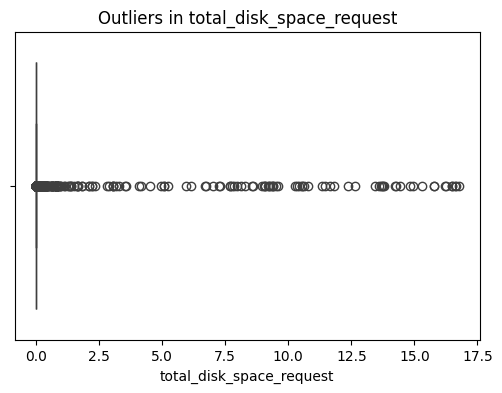

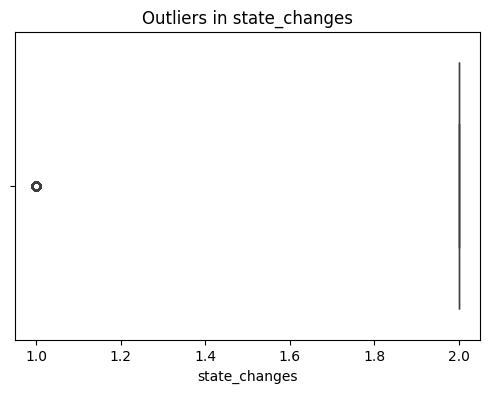

In [126]:
# Boxplot for outlier detection
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train_data, x=col)
    plt.title(f'Outliers in {col}')
    plt.show()

### Model training and evaluation

In [127]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Assuming you already have 'X' as features and 'y' as target
# X = your_feature_matrix
# y = your_target_vector

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (important for models like SVM, KNN, and Neural Networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=500)
}

# Define the hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 5, 10, 20, 30], ##### change unique to this file
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Naive Bayes': {
        # Naive Bayes does not have many hyperparameters to tune
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (100, 100)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }
}

# Function to perform GridSearchCV for hyperparameter tuning
def tune_model(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Store the best models and results
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    best_model, best_params = tune_model(model, param_grids[model_name])
    best_models[model_name] = {'model': best_model, 'params': best_params}
    print(f"Best Parameters for {model_name}: {best_params}")

# Evaluate the best models on the test set
for model_name, best_model_info in best_models.items():
    best_model = best_model_info['model']
    y_pred = best_model.predict(X_test)
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

# Optionally, you can use RandomizedSearchCV for a faster approach with large search spaces


Tuning Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Tuning Random Forest...
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Tuning Gradient Boosting...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Tuning SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Tuning KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Tuning Naive Bayes...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Param

In [128]:
# # Step 1: Join job_events with task_events on 'job_id'
# combined_data = job_events.merge(task_events, on='job_id', how='left')

# # Step 2: Join the result with machine_events on 'machine_id' (from task_events)
# combined_data = combined_data.merge(machine_events, on='machine_id', how='left')

# # Step 3: Join with task_usage on 'job_id' and 'task_index'
# combined_data = combined_data.merge(task_usage, on=['job_id', 'task_index'], how='left')

# # Step 4: Feature engineering for failure prediction (create labels)
# # Example: Assuming a failure occurs if event_type is > 1
# combined_data['failure'] = combined_data['event_type'].apply(lambda x: 1 if x > 1 else 0)

# # Step 5: Handle missing data (for simplicity, dropping rows with NaN)
# combined_data = combined_data.dropna()

# # Step 6: Optional: Convert columns to appropriate types
# combined_data['job_id'] = combined_data['job_id'].astype(int)
# combined_data['task_index'] = combined_data['task_index'].astype(int)
# combined_data['machine_id'] = combined_data['machine_id'].astype(int)


In [129]:
combined_data

NameError: name 'combined_data' is not defined

In [ ]:
# # Step 1: Aggregate Task-Level Data
# # Calculate task-level metrics
# task_metrics = task_events.groupby("job_id").agg({
#     "cpu_request": "mean",
#     "memory_request": "max",
#     "event_type": lambda x: (x == 3).sum(),  # Count failed tasks
# }).reset_index()

# # Rename columns for clarity
# task_metrics.rename(columns={
#     "cpu_request": "avg_cpu_request",
#     "memory_request": "max_memory_request",
#     "event_type": "failed_task_count"
# }, inplace=True)

# # Add total task count
# total_tasks = task_events.groupby("job_id")["task_index"].count().reset_index()
# total_tasks.rename(columns={"task_index": "total_task_count"}, inplace=True)
# task_metrics = pd.merge(task_metrics, total_tasks, on="job_id")

# # Step 2: Merge with Job-Level Data
# job_data = job_events[["job_id", "scheduling_class", "priority"]].drop_duplicates()
# combined = pd.merge(task_metrics, job_data, on="job_id", how="left")

# # Step 3: Add Machine-Level Features
# machine_failures = machine_events.groupby("machine_id")["event_type"].sum().reset_index()
# machine_failures.rename(columns={"event_type": "machine_failure_count"}, inplace=True)
# combined = pd.merge(combined, task_events[["job_id", "machine_id"]].drop_duplicates(), on="job_id", how="left")
# combined = pd.merge(combined, machine_failures, on="machine_id", how="left")

# # Step 4: Add Resource Usage Metrics
# usage_metrics = task_usage.groupby("job_id").agg({
#     "cpu_usage": "mean",
#     "memory_usage": "mean"
# }).reset_index()
# combined = pd.merge(combined, usage_metrics, on="job_id", how="left")

# # Step 5: Label Jobs (Target Variable)
# combined["job_failed"] = (combined["failed_task_count"] > 0).astype(int)

# # Step 6: Drop Unnecessary Columns and Save
# combined.drop(columns=["machine_id"], inplace=True)
# combined.to_csv("combined_data.csv", index=False)

# print("Combined dataset saved as 'combined_data.csv'")

In [ ]:
combined_data.columns

In [ ]:
combined_data.info()

In [ ]:
combined_data.shape[0]

#### compilation trial 2

In [ ]:
job_events[job_events["timestamp"] == 0]

In [ ]:
rows = job_events[job_events["timestamp"] == 0]

rows[rows["job_id"] == 3418309]

In [ ]:
job_events[job_events["job_id"] == 6251663901]
